In [3]:
import tensorflow as tf
import numpy as np
import os

In [4]:
def get_files(file_dir):
    cats = []
    label_cats = []
    dogs = []
    label_dogs = []
    for file in os.listdir(file_dir):
        name = file.split(sep='.')
        if 'cat' in name[0]:
            cats.append(file_dir + file)
            label_cats.append(0)
        else:
            if 'dog' in name[0]:
                dogs.append(file_dir + file)
                label_dogs.append(1)
        image_list = np.hstack((cats,dogs))
        label_list = np.hstack((label_cats,label_dogs))
            # print('There are %d cats\nThere are %d dogs' %(len(cats), len(dogs)))
            # 多个种类分别的时候需要把多个种类放在一起，打乱顺序,这里不需要

    # 把标签和图片都放倒一个 temp 中 然后打乱顺序，然后取出来
    temp = np.array([image_list,label_list])
    temp = temp.transpose()
    # 打乱顺序
    np.random.shuffle(temp)

    # 取出第一个元素作为 image 第二个元素作为 label
    image_list = list(temp[:,0])
    label_list = list(temp[:,1])
    label_list = [int(i) for i in label_list]  
    return image_list,label_list

In [5]:
def get_batch(image,label,image_W,image_H,batch_size,capacity):
    # 转换数据为 ts 能识别的格式
    image = tf.cast(image,tf.string)
    label = tf.cast(label, tf.int32)

    # 将image 和 label 放倒队列里 
    input_queue = tf.train.slice_input_producer([image,label])
    label = input_queue[1]
    # 读取图片的全部信息
    image_contents = tf.read_file(input_queue[0])
    # 把图片解码，channels ＝3 为彩色图片, r，g ，b  黑白图片为 1 ，也可以理解为图片的厚度
    image = tf.image.decode_jpeg(image_contents,channels =3)
    # 将图片以图片中心进行裁剪或者扩充为 指定的image_W，image_H
    image = tf.image.resize_image_with_crop_or_pad(image, image_W, image_H)
    # 对数据进行标准化,标准化，就是减去它的均值，除以他的方差
    image = tf.image.per_image_standardization(image)

    # 生成批次  num_threads 有多少个线程根据电脑配置设置  capacity 队列中 最多容纳图片的个数  tf.train.shuffle_batch 打乱顺序，
    image_batch, label_batch = tf.train.batch([image, label],batch_size = batch_size, num_threads = 64, capacity = capacity)

    # 重新定义下 label_batch 的形状
    label_batch = tf.reshape(label_batch , [batch_size])
    # 转化图片
    image_batch = tf.cast(image_batch,tf.float32)
    return  image_batch, label_batch

In [6]:
def inference(images, batch_size, n_classes):  

# conv1   卷积层 1
# pooling1_lrn  池化层 1
# conv2  卷积层 2
# pooling2_lrn 池化层 2
# local3 全连接层 1
# local4 全连接层 2
# softmax 全连接层 3
    
    with tf.variable_scope('conv1') as scope: 
     # 卷积盒的为 3*3 的卷积盒，图片厚度是3，输出是16个featuremap
        weights = tf.get_variable('weights',  
                                  shape=[3, 3, 3, 16],  
                                  dtype=tf.float32,  
                                  initializer=tf.truncated_normal_initializer(stddev=0.1, dtype=tf.float32))  
        biases = tf.get_variable('biases',  
                                 shape=[16],  
                                 dtype=tf.float32,  
                                 initializer=tf.constant_initializer(0.1))  
        conv = tf.nn.conv2d(images, weights, strides=[1, 1, 1, 1], padding='SAME')  
        pre_activation = tf.nn.bias_add(conv, biases)  
        conv1 = tf.nn.relu(pre_activation, name=scope.name)  

    with tf.variable_scope('pooling1_lrn') as scope:  
            pool1 = tf.nn.max_pool(conv1, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME', name='pooling1')  
            norm1 = tf.nn.lrn(pool1, depth_radius=4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm1')  

    with tf.variable_scope('conv2') as scope:  
                weights = tf.get_variable('weights',  
                                          shape=[3, 3, 16, 16],  
                                          dtype=tf.float32,  
                                          initializer=tf.truncated_normal_initializer(stddev=0.1, dtype=tf.float32))  
                biases = tf.get_variable('biases',  
                                         shape=[16],  
                                         dtype=tf.float32,  
                                         initializer=tf.constant_initializer(0.1))  
                conv = tf.nn.conv2d(norm1, weights, strides=[1, 1, 1, 1], padding='SAME')  
                pre_activation = tf.nn.bias_add(conv, biases)  
                conv2 = tf.nn.relu(pre_activation, name='conv2')  

    # pool2 and norm2  
    with tf.variable_scope('pooling2_lrn') as scope:  
        norm2 = tf.nn.lrn(conv2, depth_radius=4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm2')  
        pool2 = tf.nn.max_pool(norm2, ksize=[1, 3, 3, 1], strides=[1, 1, 1, 1], padding='SAME', name='pooling2')  

    with tf.variable_scope('local3') as scope:  
        reshape = tf.reshape(pool2, shape=[batch_size, -1])  
        dim = reshape.get_shape()[1].value  
        weights = tf.get_variable('weights',  
                                  shape=[dim, 128],  
                                  dtype=tf.float32,  
                                  initializer=tf.truncated_normal_initializer(stddev=0.005, dtype=tf.float32))  
        biases = tf.get_variable('biases',  
                                 shape=[128],  
                                 dtype=tf.float32,  
                                 initializer=tf.constant_initializer(0.1))  
    local3 = tf.nn.relu(tf.matmul(reshape, weights) + biases, name=scope.name)  

    # local4  
    with tf.variable_scope('local4') as scope:  
        weights = tf.get_variable('weights',  
                                  shape=[128, 128],  
                                  dtype=tf.float32,  
                                  initializer=tf.truncated_normal_initializer(stddev=0.005, dtype=tf.float32))  
        biases = tf.get_variable('biases',  
                                 shape=[128],  
                                 dtype=tf.float32,  
                                 initializer=tf.constant_initializer(0.1))  
        local4 = tf.nn.relu(tf.matmul(local3, weights) + biases, name='local4')  

    # softmax  
    with tf.variable_scope('softmax_linear') as scope:  
        weights = tf.get_variable('softmax_linear',  
                                  shape=[128, n_classes],  
                                  dtype=tf.float32,  
                                  initializer=tf.truncated_normal_initializer(stddev=0.005, dtype=tf.float32))  
        biases = tf.get_variable('biases',  
                                 shape=[n_classes],  
                                 dtype=tf.float32,  
                                 initializer=tf.constant_initializer(0.1))  
        softmax_linear = tf.add(tf.matmul(local4, weights), biases, name='softmax_linear')  

    return softmax_linear  



def losses(logits, labels):  
    with tf.variable_scope('loss') as scope:  
        cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits \
                        (logits=logits, labels=labels, name='xentropy_per_example')  
        loss = tf.reduce_mean(cross_entropy, name='loss')  
        tf.summary.scalar(scope.name + '/loss', loss)  
    return loss  

def trainning(loss, learning_rate):  
    with tf.name_scope('optimizer'):  
        optimizer = tf.train.AdamOptimizer(learning_rate= learning_rate)  
        global_step = tf.Variable(0, name='global_step', trainable=False)  
        train_op = optimizer.minimize(loss, global_step= global_step)  
    return train_op  

def evaluation(logits, labels):  
    with tf.variable_scope('accuracy') as scope:  
        correct = tf.nn.in_top_k(logits, labels, 1)  
        correct = tf.cast(correct, tf.float16)  
        accuracy = tf.reduce_mean(correct)  
        tf.summary.scalar(scope.name + '/accuracy', accuracy)  
    return accuracy

In [7]:
import tensorflow as tf

def inference(images, batch_size, n_classes):
    # conv1, shape = [kernel_size, kernel_size, channels, kernel_numbers]
    with tf.variable_scope("conv1") as scope:
        weights = tf.get_variable("weights",
                                  shape=[3, 3, 3, 16],
                                  dtype=tf.float32,
                                  initializer=tf.truncated_normal_initializer(stddev=0.1, dtype=tf.float32))
        biases = tf.get_variable("biases",
                                 shape=[16],
                                 dtype=tf.float32,
                                 initializer=tf.constant_initializer(0.1))
        conv = tf.nn.conv2d(images, weights, strides=[1, 1, 1, 1], padding="SAME")
        pre_activation = tf.nn.bias_add(conv, biases)
        conv1 = tf.nn.relu(pre_activation, name="conv1")

    # pool1 && norm1
    with tf.variable_scope("pooling1_lrn") as scope:
        pool1 = tf.nn.max_pool(conv1, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1],
                               padding="SAME", name="pooling1")
        norm1 = tf.nn.lrn(pool1, depth_radius=4, bias=1.0, alpha=0.001/9.0,
                          beta=0.75, name='norm1')

    # conv2
    with tf.variable_scope("conv2") as scope:
        weights = tf.get_variable("weights",
                                  shape=[3, 3, 16, 16],
                                  dtype=tf.float32,
                                  initializer=tf.truncated_normal_initializer(stddev=0.1, dtype=tf.float32))
        biases = tf.get_variable("biases",
                                 shape=[16],
                                 dtype=tf.float32,
                                 initializer=tf.constant_initializer(0.1))
        conv = tf.nn.conv2d(norm1, weights, strides=[1, 1, 1, 1], padding="SAME")
        pre_activation = tf.nn.bias_add(conv, biases)
        conv2 = tf.nn.relu(pre_activation, name="conv2")

    # pool2 && norm2
    with tf.variable_scope("pooling2_lrn") as scope:
        pool2 = tf.nn.max_pool(conv2, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1],
                               padding="SAME", name="pooling2")
        norm2 = tf.nn.lrn(pool2, depth_radius=4, bias=1.0, alpha=0.001/9.0,
                          beta=0.75, name='norm2')

    # full-connect1
    with tf.variable_scope("fc1") as scope:
        reshape = tf.reshape(norm2, shape=[batch_size, -1])
        dim = reshape.get_shape()[1].value
        weights = tf.get_variable("weights",
                                  shape=[dim, 128],
                                  dtype=tf.float32,
                                  initializer=tf.truncated_normal_initializer(stddev=0.005, dtype=tf.float32))
        biases = tf.get_variable("biases",
                                 shape=[128],
                                 dtype=tf.float32,
                                 initializer=tf.constant_initializer(0.1))
        fc1 = tf.nn.relu(tf.matmul(reshape, weights) + biases, name="fc1")

    # full_connect2
    with tf.variable_scope("fc2") as scope:
        weights = tf.get_variable("weights",
                                  shape=[128, 128],
                                  dtype=tf.float32,
                                  initializer=tf.truncated_normal_initializer(stddev=0.005, dtype=tf.float32))
        biases = tf.get_variable("biases",
                                 shape=[128],
                                 dtype=tf.float32,
                                 initializer=tf.constant_initializer(0.1))
        fc2 = tf.nn.relu(tf.matmul(fc1, weights) + biases, name="fc2")

    # softmax
    with tf.variable_scope("softmax_linear") as scope:
        weights = tf.get_variable("weights",
                                  shape=[128, n_classes],
                                  dtype=tf.float32,
                                  initializer=tf.truncated_normal_initializer(stddev=0.005, dtype=tf.float32))
        biases = tf.get_variable("biases",
                                 shape=[n_classes],
                                 dtype=tf.float32,
                                 initializer=tf.constant_initializer(0.1))
        softmax_linear = tf.add(tf.matmul(fc2, weights), biases, name="softmax_linear")
        softmax_linear = tf.nn.softmax(softmax_linear)
    return softmax_linear

In [8]:
N_CLASSES = 2  # 2个输出神经元，［1，0］ 或者 ［0，1］猫和狗的概率
IMG_W = 208  # 重新定义图片的大小，图片如果过大则训练比较慢  
IMG_H = 208  
BATCH_SIZE = 32  #每批数据的大小
CAPACITY = 256  
MAX_STEP = 15000 # 训练的步数，应当 >= 10000
learning_rate = 0.0001 # 学习率，建议刚开始的 learning_rate <= 0.0001


def run_training():  

    # 数据集
    train_dir = './data/train/'     
    #logs_train_dir 存放训练模型的过程的数据，在tensorboard 中查看 
    logs_train_dir = './logs/saveNet/'  

    # 获取图片和标签集
    train, train_label = get_files(train_dir)  
    # 生成批次
    train_batch, train_label_batch = get_batch(train,  
                                                          train_label,  
                                                          IMG_W,  
                                                          IMG_H,  
                                                          BATCH_SIZE,   
                                                          CAPACITY)
    # 进入模型
    train_logits = inference(train_batch, BATCH_SIZE, N_CLASSES) 
    # 获取 loss 
    train_loss = losses(train_logits, train_label_batch)
    # 训练 
    train_op = trainning(train_loss, learning_rate)
    # 获取准确率 
    train__acc = evaluation(train_logits, train_label_batch)  
    # 合并 summary
    summary_op = tf.summary.merge_all()  
    sess = tf.Session()
    # 保存summary
    train_writer = tf.summary.FileWriter(logs_train_dir, sess.graph)  
    saver = tf.train.Saver()  

    sess.run(tf.global_variables_initializer())  
    coord = tf.train.Coordinator()  
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)  

    try:  
        for step in np.arange(MAX_STEP):  
            if coord.should_stop():  
                    break  
            _, tra_loss, tra_acc = sess.run([train_op, train_loss, train__acc])  

            if step % 50 == 0:  
                print('Step %d, train loss = %.2f, train accuracy = %.2f%%' %(step, tra_loss, tra_acc*100.0))  
                summary_str = sess.run(summary_op)  
                train_writer.add_summary(summary_str, step)  

            if step % 500 == 0 or (step + 1) == MAX_STEP:  
                # 每隔2000步保存一下模型，模型保存在 checkpoint_path 中
                checkpoint_path = os.path.join(logs_train_dir, 'model.ckpt')  
                saver.save(sess, checkpoint_path, global_step=step)  

    except tf.errors.OutOfRangeError:  
        print('Done training -- epoch limit reached')  
    finally:  
        coord.request_stop()
    coord.join(threads)  
    sess.close()  

# train
run_training()

Step 0, train loss = 0.69, train accuracy = 53.12%
Step 50, train loss = 0.69, train accuracy = 40.62%
Step 100, train loss = 0.70, train accuracy = 53.12%
Step 150, train loss = 0.69, train accuracy = 50.00%
Step 200, train loss = 0.68, train accuracy = 53.12%
Step 250, train loss = 0.67, train accuracy = 62.50%
Step 300, train loss = 0.66, train accuracy = 65.62%
Step 350, train loss = 0.68, train accuracy = 59.38%
Step 400, train loss = 0.61, train accuracy = 75.00%
Step 450, train loss = 0.63, train accuracy = 71.88%
Step 500, train loss = 0.66, train accuracy = 59.38%
Step 550, train loss = 0.65, train accuracy = 62.50%
Step 600, train loss = 0.69, train accuracy = 46.88%
Step 650, train loss = 0.66, train accuracy = 59.38%
Step 700, train loss = 0.64, train accuracy = 59.38%
Step 750, train loss = 0.71, train accuracy = 56.25%
Step 800, train loss = 0.58, train accuracy = 75.00%
Step 850, train loss = 0.67, train accuracy = 56.25%
Step 900, train loss = 0.58, train accuracy = 75.

KeyboardInterrupt: 

In [9]:
from PIL import Image
import matplotlib.pyplot as plt

def get_one_image(train): 
    files = os.listdir(train)
    n = len(files)
    ind = np.random.randint(0,n)
    img_dir = os.path.join(train,files[ind])  
    image = Image.open(img_dir)  
    plt.imshow(image)
    plt.show()
    image = image.resize([208, 208])  
    image = np.array(image)
    return image  

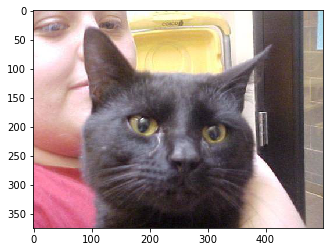

array([[[224, 186, 185],
        [222, 182, 182],
        [213, 173, 173],
        ..., 
        [195, 224, 232],
        [187, 224, 233],
        [186, 223, 232]],

       [[216, 176, 176],
        [209, 169, 169],
        [211, 171, 171],
        ..., 
        [184, 217, 226],
        [173, 213, 223],
        [176, 216, 226]],

       [[210, 170, 168],
        [205, 165, 163],
        [211, 171, 169],
        ..., 
        [181, 219, 230],
        [170, 216, 231],
        [171, 215, 228]],

       ..., 
       [[205,  85, 133],
        [211,  91, 139],
        [215,  93, 140],
        ..., 
        [164, 146, 146],
        [164, 146, 146],
        [163, 146, 139]],

       [[201,  81, 129],
        [208,  88, 136],
        [213,  91, 138],
        ..., 
        [163, 145, 145],
        [163, 145, 145],
        [160, 143, 136]],

       [[195,  75, 123],
        [203,  83, 131],
        [208,  86, 133],
        ..., 
        [164, 146, 146],
        [165, 147, 147],
        [164, 147,

In [19]:
train = './data/test/'
get_one_image(train)

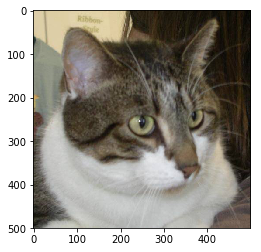

从指定的路径中加载模型。。。。
INFO:tensorflow:Restoring parameters from ./logs/saveNet/model.ckpt-1000
模型加载成功, 训练的步数为 1000
猫的概率 0.709691


In [64]:
def evaluate_one_image():  
    #存放的是从百度下载的猫狗图片路径
    train = './data/test/' 
    image_array = get_one_image(train)  

    with tf.Graph().as_default():  
        BATCH_SIZE = 1  # 因为只读取一副图片 所以batch 设置为1
        N_CLASSES = 2  # 2个输出神经元，［1，0］ 或者 ［0，1］猫和狗的概率
        # 转化图片格式
        image = tf.cast(image_array, tf.float32)  
        # 图片标准化
        image = tf.image.per_image_standardization(image)
        # 图片原来是三维的 [208, 208, 3] 重新定义图片形状 改为一个4D  四维的 tensor
        image = tf.reshape(image, [1, 208, 208, 3])  
        logit = inference(image, BATCH_SIZE, N_CLASSES)  
        # 因为 inference 的返回没有用激活函数，所以在这里对结果用softmax 激活
        logit = tf.nn.softmax(logit)  

        # 用最原始的输入数据的方式向模型输入数据 placeholder
        x = tf.placeholder(tf.float32, shape=[208, 208, 3])  

        # 我门存放模型的路径
        logs_train_dir = './logs/saveNet/'   
        # 定义saver 
        saver = tf.train.Saver()  

        with tf.Session() as sess:  

            print("从指定的路径中加载模型。。。。")
            # 将模型加载到sess 中 
            ckpt = tf.train.get_checkpoint_state(logs_train_dir)  
            if ckpt and ckpt.model_checkpoint_path:  
                global_step = ckpt.model_checkpoint_path.split('/')[-1].split('-')[-1]  
                saver.restore(sess, ckpt.model_checkpoint_path)  
                print('模型加载成功, 训练的步数为 %s' % global_step)  
            else:  
                print('模型加载失败，，，文件没有找到')  
            # 将图片输入到模型计算
            prediction = sess.run(logit, feed_dict={x: image_array})
            # 获取输出结果中最大概率的索引
            max_index = np.argmax(prediction)  
            if max_index==0:  
                print('猫的概率 %.6f' %prediction[:, 0])  
            else:  
                print('狗的概率 %.6f' %prediction[:, 1]) 
# 测试
evaluate_one_image()